In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

In [200]:
# matplotlib library load
import matplotlib.pyplot as plt

# plot 한글 보이게
from matplotlib import rc
rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

# 1. 데이터 전처리

In [201]:
data = pd.read_csv(r"../data/new_Data.csv", encoding='CP949')

C:\Users\user\AppData\Local\Temp\ipykernel_28264\3543840705.py:1: DtypeWarning: Columns (3,4,7,9,13,18,19,21,23,27,28,29,30,33,38,39,40,42,44,48,51,54,55,57,59,61,63,64,66,67,68,69,70,74,75,79,80,84,88,90,91,92,93,94,97,98,99,101,106,109,113,115,116,117,121,122,125,129,130,132,133,136,137,138,142,144,145,147,149,150,153,154,156,159,163,164,166,167,169,170,171,175,176,177,183,184,185,189,196,198,199,201,202,204,205,206,209,211,213,214,215,217,218,219,220,223,227,231,233,234,235,238,239,244,247,248,251,254,255,257,260,261,264,266,268,270,271,273,279,281,283,285,287,288,290,291,294,295,298,300,302,303,304,306,307,311,313,316,317,322,324,325,328,332,335,336,346,347,351,352,353,354,355,356,357,361,362,364,366,370,372,375,377,378,379,381,387,388,389,390,396,397,398,399,403,404,408,409,410,411,412,414,417,418,419,420,421,424,427,429,430,431,435,436,437,438,439,440,444,446,447,448,449,450,451,453,456,463,466,467,469,471,472,474,476,477,478,479,480,485,490,492,495,496,497,502,503,504,506,509,51

In [202]:
data.columns = data.iloc[0]
data = data.iloc[1:]
data.set_index('Symbol Name', inplace=True)
data = data.replace(',', '', regex=True).astype(float)

In [203]:
j = 1

#total_data = data.iloc[256*j:-256*(4-j),:]
total_data = data.iloc[256*j:,:]

In [204]:
total_data = total_data.dropna(axis=1)

In [205]:
# 각 컬럼별 결측값의 개수를 계산
null_counts = total_data.isnull().sum()

# 결측값이 있는 컬럼과 그 개수를 출력
print(null_counts[null_counts > 0])


Series([], dtype: int64)


In [206]:
train_data = total_data.iloc[:4119]
val_data = total_data.iloc[3089:3089+514*2]
test_data = total_data.iloc[3089+514*2:]

In [207]:
print('행 :', len(train_data), '열 :', len(train_data.T))
print('행 :', len(val_data), '열 :', len(val_data.T))
print('행 :', len(test_data), '열 :', len(test_data.T))

행 : 4119 열 : 469
행 : 1028 열 : 469
행 : 1800 열 : 469


# 2.1. 군집화 기반 앙상블 페어선정 알고리즘 - 변형(GLS)

In [208]:
data = train_data
data = np.log(data / data.shift(1))
data = data.dropna(axis=0)
log_return_data = data

In [209]:
scaler = StandardScaler()
datanp = scaler.fit_transform(data)
data = pd.DataFrame(datanp, index=data.index, columns=data.columns)

In [210]:
from sklearn.decomposition import PCA
pca = PCA(n_components=15) # 주성분을 몇개로 할지 결정
principalComponents = pca.fit_transform(data)
print(pca.explained_variance_)

[85.54871295  7.68565252  4.96285964  4.25304918  3.85101182  3.40962078
  3.20992082  2.76749887  2.39678865  2.21320906  2.11806888  2.03514332
  1.92019937  1.84432533  1.75314389]


In [211]:
from scipy.linalg import svd

U,S,VT = svd(data)

pca_df = pd.DataFrame(VT.T[:,0:15], columns=[f'PC{i+1}' for i in range(15)], index=data.columns)

In [212]:
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
0,,,,,,,,,,,,,,,
삼성전자,0.058344,-0.090175,0.047870,-0.060043,0.133192,-0.032371,0.073783,-0.023967,0.026163,-0.002991,-0.150060,0.002958,-0.103457,0.020213,-0.021983
SK하이닉스,0.053933,-0.042598,-0.027694,-0.077123,0.084863,-0.037394,0.063895,0.026676,-0.029578,0.034783,-0.058391,-0.002328,-0.052260,0.030624,-0.002260
현대차,0.053791,-0.111822,0.006977,-0.012709,0.123880,-0.044580,0.119523,-0.076015,-0.087859,-0.152971,0.047900,0.014360,-0.144057,0.056509,-0.070675
기아,0.052588,-0.090184,0.007756,0.014072,0.096266,-0.040329,0.124348,-0.070993,-0.054349,-0.147952,0.070671,0.015402,-0.130166,0.038839,-0.063459
POSCO홀딩스,0.055043,-0.106197,0.054804,0.069195,-0.011816,-0.007321,0.043893,0.032892,0.021673,-0.069711,-0.137543,-0.060086,-0.144873,0.003974,0.009558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
금호전기,0.061093,-0.018334,-0.012403,-0.025530,0.065614,-0.015321,0.036758,-0.005079,0.003897,0.062354,-0.006381,-0.001377,0.015094,0.008671,-0.020116
한솔PNS,0.043734,0.022240,-0.015781,-0.007983,0.043709,0.004567,0.006684,0.014021,0.003380,0.065710,0.002973,0.029518,0.019461,-0.014904,0.004155
한창,0.035360,0.040690,-0.039918,-0.048584,0.040318,-0.000659,0.009862,0.080987,0.014286,-0.021684,-0.059462,-0.017071,-0.026441,-0.033720,-0.038941


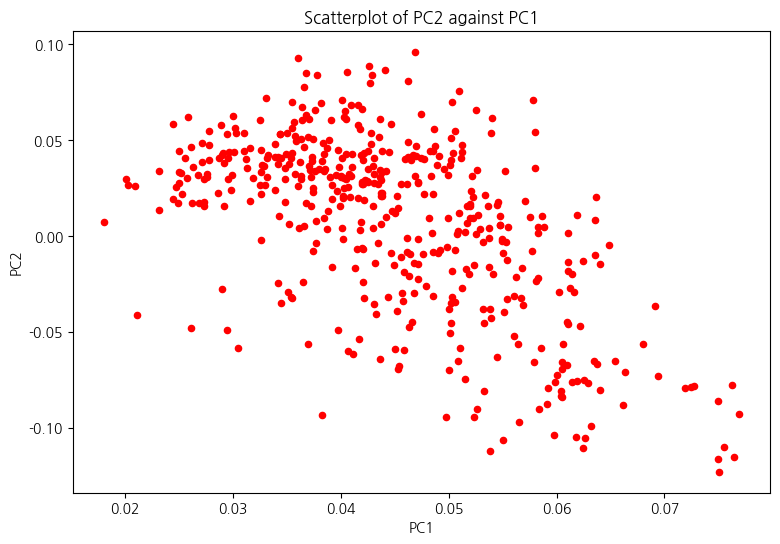

In [213]:
'''
Visualising the PCA in dimension R^2 (PC1 and PC2)
'''

fig, ax = plt.subplots(figsize=(9,6))
pca_df.plot(x="PC1", y="PC2", kind="scatter", marker="o",
    title="Scatterplot of PC2 against PC1", ax=ax, color="r")
plt.show()

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\

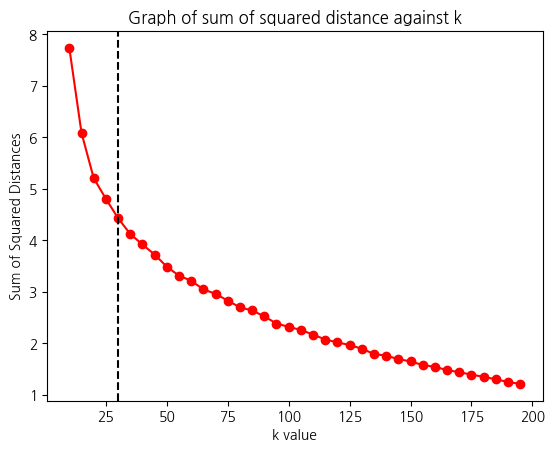

From the graph above, we can see that the optimal k-value is at the elbow, at k = 30


In [214]:
'''Make a pointer to store clustering results'''

cluster_results = {}

'''K-Means Clustering'''

def optimise_k(pca_df):

    error = []
    ks = []
    
    for i in range(10, 200, 5): # For loop from 10 to 200 with intervals of 5 and calculate the respective sum of squared distances for i number of centroids

        # Initialise the KMeans function with the i number of centroids.
        # By default, KMeans function uses the KMeans++ Method of initialisation the centroids.
        kmeans = KMeans(n_clusters=i) 
        
        # Fits the model with pcd_df and applies KMeans algorithm on pca_df.
        kmeans.fit(pca_df)
        
        # Using the attribute ".inertia_" returns the sum of squared distances of datapoints to their closest cluster center.
        # It is appended into error to be plotted as the y-axis.
        error.append(kmeans.inertia_)
        
        # The number of centroids, i, is appended to ks to be plotted as the x-axis.
        ks.append(i)
    
    # Plot graph of "Sum of Squared Distances" against "k value".
    # Using this graph, the optimal number of centroids can be found via the elbow method
    plt.plot(ks, error, marker="o", color="r")
    plt.title("Graph of sum of squared distance against k")
    plt.xlabel("k value")
    plt.ylabel("Sum of Squared Distances")
    plt.axvline(30, color='black', linestyle='--')
    plt.show()

def cluster_kmeans(pca_df, k):

    # Initialise the KMeans function with the k number of centroids.
    kmeans = KMeans(n_clusters=k)

    # Fits the model with pcd_df and applies KMeans algorithm on pca_df.
    kmeans.fit(pca_df)

    # Using the method .predict(X), it calculates the closest cluster each datapoint in dataset X belongs to.
    results = kmeans.predict(pca_df)

    # Plot the cluster results.
    fig, ax = plt.subplots(figsize=(9,6))
    pca_df.plot(x="PC1", y="PC2", kind="scatter", 
        title=f"K-Means Cluster Results, k={k}", c=results, cmap="jet", ax=ax)
    plt.show()
    return results

optimise_k(pca_df)
print(f"From the graph above, we can see that the optimal k-value is at the elbow, at k = 30")

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


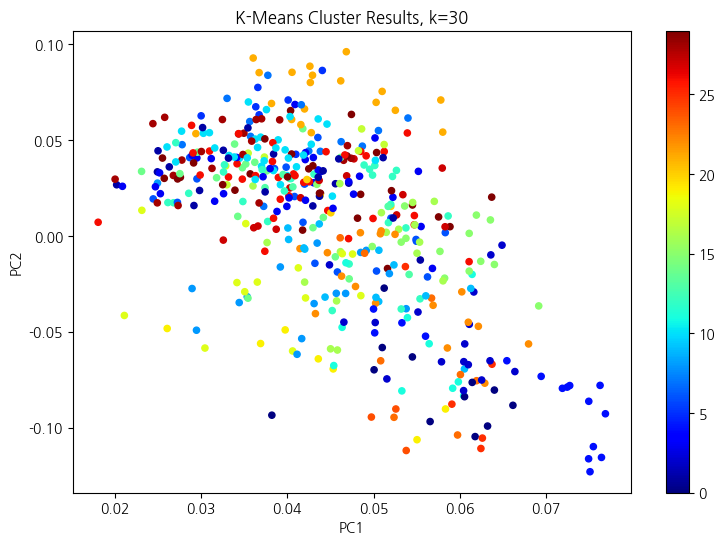

Therefore, we plot the K-Means results for the optimal k-value, 30


In [215]:
'''Plotting the K-Means Cluster Results'''

# K-Means Clustering is applied on pca_df for k = 45
kmeans_results = cluster_kmeans(pca_df,k=30)

# K-Means Clustering results are saved in cluster_results
cluster_results[f"KMeans"] = kmeans_results

print(f"Therefore, we plot the K-Means results for the optimal k-value, 30")

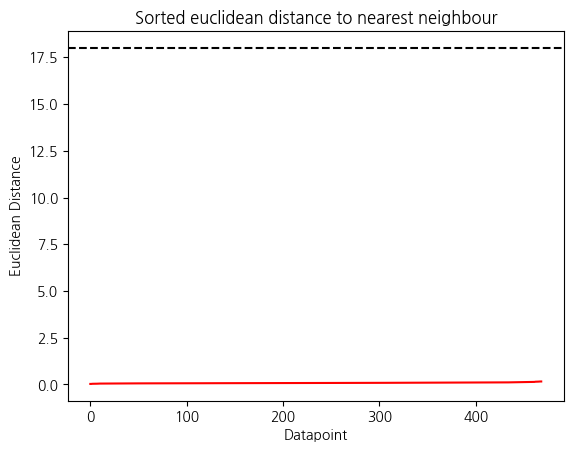

From the graph above, we can see that the optimal epsilon is at the elbow, at epsilon = 18


In [216]:
'''
DBSCAN Clustering:
'''

def optimise_epsilon(pca_df):

    # Initialise the NearestNeighbors function with 2 neighbors 
    # This is to find optimal value of epsilon based on an optimisation algorithm
    neigh = NearestNeighbors(n_neighbors=2)

    # Fits the model with pcd_df
    nbrs = neigh.fit(pca_df)

    # Using the method .kneighbors(X), the k-Neighbours for datatpoints in datatset X are found
    # By default, this method returns the distances array which is found in the 0 index
    distances = nbrs.kneighbors(pca_df)[0]

    # Sort distances row-wise
    distances = np.sort(distances,axis=0) 

    # Remove the 0-index value (Euclidean distance to itself which is 0)
    distances = distances[:,1:]

    # Plot graph of "Euclidean Distance" against "Datapoint".
    # Using this graph, the optimal epsilon value can be found via the elbow method
    plt.plot(distances, color="r")
    plt.title("Sorted euclidean distance to nearest neighbour")
    plt.xlabel("Datapoint")
    plt.ylabel("Euclidean Distance")
    plt.axhline(y=18, color='black', linestyle='--')
    plt.show()    

def cluster_dbscan(pca_df, eps, min_samples):

    # Initialise the DBSCAN function with eps and min_samples.
    # eps is a float value and is the maximum distance between two samples for one to be considered as in the neighborhood of the other
    # min_samples is the number of samples (or total weight) in a neighborhood for a point to be considered as a core point. 
    # This includes the point itself.
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)

    # Using the method .fit_predict(X), clusters from a data or distance matrix and predict labels are computed
    results = dbscan.fit_predict(pca_df)
    
    # Plot the cluster results.
    fig, ax = plt.subplots(figsize=(9,6))
    pca_df.plot(x="PC1", y="PC2", kind="scatter", 
        title=f"DBSCAN Cluster Results", c=results, cmap="jet", ax=ax)
    plt.show()

    # Get number of clusters formed.
    num_clusters = np.max(results)
    print(f"For the epsilon value of {eps}, the number of clusters is {num_clusters}")

    return results

optimise_epsilon(pca_df) 
print(f"From the graph above, we can see that the optimal epsilon is at the elbow, at epsilon = 18")

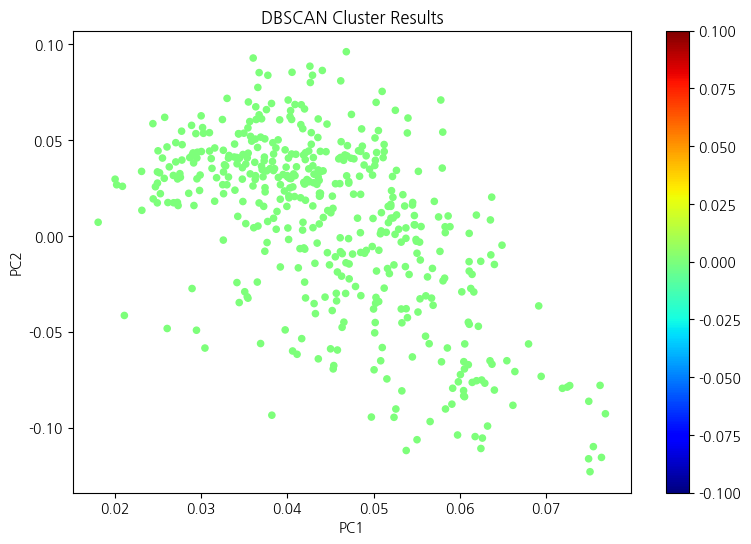

For the epsilon value of 18, the number of clusters is 0


In [217]:
'''Plotting the DBSCAN Cluster Results'''

# DBSCAN Clustering is applied on pca_df for eps = 20 and min_samples = 2
results = cluster_dbscan(pca_df, eps=18, min_samples=2)

# DBSCANS Clustering results are saved in cluster_results, a dict
cluster_results["DBSCAN"] = results

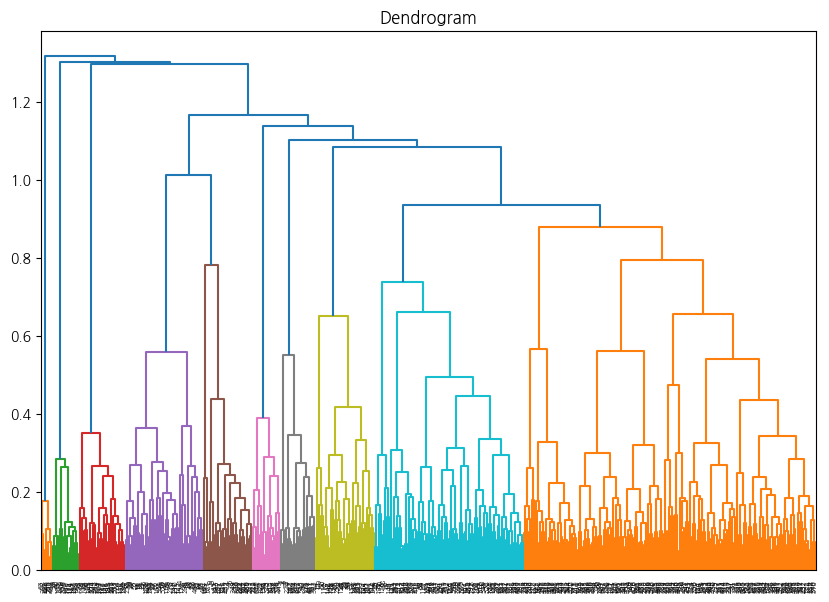

In [218]:
'''
Hierarchical Clustering (AgglomerativeClustering)
'''

def cluster_hierar(pca_df, n):

    # Initialise the AgglomerativeClustering function with n clusters.
    # Fits the model with pca_df and applies Agglomerative Clustering algorithm on pca_df.
    hierar = AgglomerativeClustering(n_clusters=n, ).fit(pca_df)

    # Using the method .fit_predict(X), it fits and return the result of each datapoint's clustering assignment.
    results = hierar.fit_predict(pca_df)

    # Plot cluster results.
    fig, ax = plt.subplots(figsize=(9,6))
    pca_df.plot(x="PC1", y="PC2", kind="scatter", 
        title=f"Agglomerative Clustering Results, n={n}", c=results, cmap="jet", ax=ax)
    plt.show()

    return results

def draw_dendrogram(pca_df):
    
    # Initialise Linkage function with linkage method = "ward".
    # linkage returns a linkage matrix, which is needed for the dendrogram to be plotted.
    linked = linkage(pca_df,method = "ward") 

    # Plot dendrogram results.
    plt.figure(figsize =(10,7))
    plt.title("Dendrogram")
    dendrogram(linked,
                orientation = "top",
                distance_sort = "descreasing",
                show_leaf_counts = True)
    plt.show()

draw_dendrogram(pca_df)

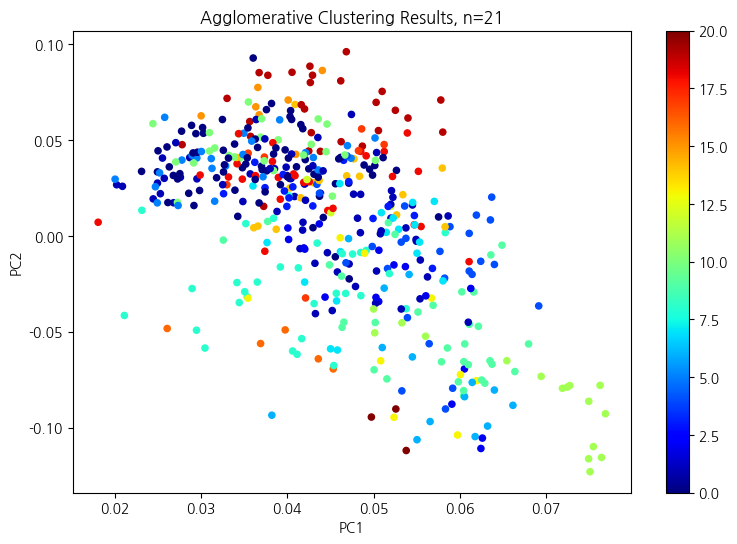

In the case of Hierarchical Clustering, we chose the optimal number of clusters to be sqrt(N)=22, where N is the number of datapoints


In [219]:
'''Plotting the Hierarchical Cluster Results'''
# Hierarchical Clustering is applied on pca_df for n_clusters = sqrt(N)
results = cluster_hierar(pca_df, int(pca_df.shape[0]**0.5)) 

# Hierarchical Clustering results are saved in cluster_results
cluster_results["Hierarchical"] = results

print(f"In the case of Hierarchical Clustering, we chose the optimal number of clusters to be sqrt(N)=22, where N is the number of datapoints")

In [220]:
'''
Cluster Results -> Groupings of stocks/ETFs:
1. First, we need to map the cluster ids to the symbols of our stocks to get groups of stocks
2. Then store the clusters into a pointer -> "groups"
'''
norm_symbols = pca_df.index

# Return array of the symbols of stocks.
print(norm_symbols.shape) 

# Contains cluster group assignments for each algorithm.
print([x.shape for x in cluster_results.values()])

def map_clusters(cluster_result):
    grouping = [[] for _ in range(max(cluster_result)+1)]
    for i, res in enumerate(cluster_result):
        grouping[res].append(norm_symbols[i])
    
    grouping = [g for g in grouping if 1<len(g)<=10] # Keep clusters with <=10 members.
    
    return grouping

groups = {}
for algorithm, cluster_result in cluster_results.items():
    groups[algorithm] = map_clusters(cluster_result)


print("Number of valid clusters:", {k:len(v) for k,v in groups.items()})
print("Example cluster:", groups["Hierarchical"][0])

(469,)
[(469,), (469,), (469,)]
Number of valid clusters: {'KMeans': 9, 'DBSCAN': 0, 'Hierarchical': 6}
Example cluster: ['삼화콘덴서', '삼화전기', '삼화전자', '성문전자']


In [221]:
for i in range(0,len(groups["KMeans"])):
    print("Example cluster:", groups["KMeans"][i])

Example cluster: ['동원산업', '사조대림', '사조산업', '신라교역', '사조오양', '한성기업', '동원수산']
Example cluster: ['SK하이닉스', '삼성SDI', 'LG', '삼성전기', '한화에어로스페이스', '신세계', 'SK네트웍스', '삼영전자', '대덕', '한국전자홀딩스']
Example cluster: ['현대비앤지스틸', '휴스틸', 'NI스틸', '동양철관', '문배철강']
Example cluster: ['DI동일', 'BYC', '만호제강', '대한화섬', '성창기업지주', '방림', '대한방직']
Example cluster: ['삼성전자', 'POSCO홀딩스', '한국전력', 'KT&G', 'SK텔레콤', 'KT', '한국가스공사']
Example cluster: ['삼화콘덴서', '삼화전기', '삼화전자', '성문전자']
Example cluster: ['삼성화재', '기업은행', 'DB손해보험', '현대해상', '코리안리', '롯데손해보험', '한화손해보험', '흥국화재']
Example cluster: ['현대차', '기아', '현대모비스']
Example cluster: ['삼성E&A', 'GS건설', 'DL', 'HDC', 'HL D&I']


In [222]:
for i in range(0,len(groups["Hierarchical"])):
    print("Example cluster:", groups["Hierarchical"][i])

Example cluster: ['삼화콘덴서', '삼화전기', '삼화전자', '성문전자']
Example cluster: ['삼성화재', '기업은행', 'DB손해보험', '현대해상', '코리안리', '롯데손해보험', '한화손해보험', '제주은행', '흥국화재']
Example cluster: ['동원산업', '사조대림', '사조산업', '신라교역', '사조오양', '한성기업', '동원수산']
Example cluster: ['한국전력', 'KT&G', 'SK텔레콤', 'KT', '한국가스공사']
Example cluster: ['태광산업', 'BYC', '만호제강', '대한화섬', '성창기업지주', '방림', '대한방직']
Example cluster: ['현대차', '기아', '현대모비스']


In [223]:
cumulative_log_returns = log_return_data.cumsum()
cumulative_returns = np.exp(cumulative_log_returns) - 1

In [224]:
import os

def clusterCumsumPlot(name_clustering_algorithm):
    save_path = fr"C:\Users\user\Desktop\논스 페트\Pairs-Trading-from-Beginning-to-End\Image\{j}"
    os.makedirs(save_path, exist_ok=True)

    for i in range(0, len(groups[name_clustering_algorithm])):
        plt.figure(figsize=(10, 6))
        cluster = groups[name_clustering_algorithm][i]
        for stock in cluster:
            if stock in cumulative_returns.columns:
                cumulative_returns[stock].plot(label=stock)
        plt.title(f'{name_clustering_algorithm} 군집화 알고리즘 - {i+1}번째 군집')
        plt.xlabel('날짜')
        plt.ylabel('누적수익률')
        plt.legend()
        plt.grid(True)
        
        image_filename = f"{name_clustering_algorithm}_cluster_{i+1}.png"
        plt.savefig(os.path.join(save_path, image_filename))
        plt.close()

In [225]:
clusterCumsumPlot("KMeans")

In [226]:
clusterCumsumPlot("Hierarchical")

In [227]:
clusterCumsumPlot("DBSCAN")

# 2.2. Validation

In [228]:
val_log_returns = np.log(val_data / val_data.shift(1))
val_log_returns = val_log_returns.dropna(axis=0)

In [229]:
def get_r_squared(group):
    df = val_log_returns[group]
    corr = df.corr() # Correlation matrix
    corr.values[np.tril_indices_from(corr)] = np.nan # Keep only upper triangular of the correlation matrix
    return corr.unstack().mean() # Return mean of the correlation matrix


def average_correlation(groups):
    avg_corr = {}
    for algorithm, cluster_result in groups.items():
        corrs = []
        for group in cluster_result:
            corr = get_r_squared(group)
            corrs.append(corr)
        avg_corr[algorithm] = np.mean(np.square(corrs)) # Take mean of r-squared 
    return avg_corr

corr_metrics = average_correlation(groups)
pd.DataFrame(corr_metrics.items(), columns=["Algorithm", "R-Squared"])

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,Algorithm,R-Squared
0,KMeans,0.086240
1,DBSCAN,NaN
2,Hierarchical,0.099186


In [230]:
from sklearn.metrics import silhouette_score

def prepare_labels(data, groups):
    # Prepare a mapping from stock names to their positions to align labels
    stock_indices = {stock: index for index, stock in enumerate(data.columns)}
    
    # Prepare labels for each algorithm
    prepared_labels = {}
    for algorithm, clusters in groups.items():
        labels = [-1] * len(data.columns)  # Initialize with -1 for any potentially unassigned stocks
        for cluster_index, stocks in enumerate(clusters):
            for stock in stocks:
                if stock in stock_indices:
                    labels[stock_indices[stock]] = cluster_index
        prepared_labels[algorithm] = labels
    return prepared_labels

def calculate_silhouette_scores(data, groups):
    prepared_labels = prepare_labels(data, groups)
    silhouette_scores = {}
    for algorithm, labels in prepared_labels.items():
        # Check if labels have been properly assigned (avoid all -1 scenario)
        if len(set(labels)) > 1:
            score = silhouette_score(data.T, labels)  # Transpose to align samples with features
            silhouette_scores[algorithm] = score
        else:
            silhouette_scores[algorithm] = None  # No valid scoring if all labels are -1
    return silhouette_scores

# Assuming `groups` contains your cluster data as previously formatted
silhouette_scores = calculate_silhouette_scores(val_log_returns, groups)


results_df = pd.DataFrame(silhouette_scores.items(), columns=["Algorithm", "Silhouette Score"])
print(results_df)

      Algorithm  Silhouette Score
0        KMeans         -0.156104
1        DBSCAN               NaN
2  Hierarchical         -0.156869


In [231]:
import json
with open('custum_1.json', 'w', encoding='utf-8') as f:
    json.dump(groups, f, ensure_ascii=False, indent=4)

---